This notebook is to demonstrate the pipeline for EMG source inversion.

In [1]:
from scipy.constants import epsilon_0
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as K0, iv as I0
from scipy.linalg import solve

from EMGinv_fns import *

from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay
from scipy.optimize import minimize

import pandas as pd
import scipy.io
import mat73
from pathlib import Path
import shutil
import os.path as op
import mne

import gc

# Remove magic commands if turning into a script
# %matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# Load electrode positions
electrode_pos = np.load('electrode_pos.npy')

# Load source space 
xscaling, yscaling, zscaling = 1.5e-4, 1.5e-4, 0.5e-2
pos = load_src_template(filename=None, xscaling=1.5e-4, yscaling=1.5e-4, zscaling=0.5e-2)

# Load forward model
fwd = np.load('fwd_dipole.npy')
# Alternative would be to generate with
# fwd = fwd_generator(dipole_potential, pos, electrode_positions)
# And then saving with np.save('fwd_dipole.npy', fwd) - Very big file

# Load muap template waveforms 
# filename = '/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/muaps_frommatlab.mat'
# muaps_1 = scipy.io.loadmat(filename)['muaps']

# Load some data - to construct covariance matrices
MNE_raw = load_tmsitomne_combine(f_prox = 'Data/Pok_2024_08_21_A_PROX_8.poly5', f_dist='Data/Pok_2024_08_21_B_DIST_8.poly5' )

(573, 969, 26)
(1485914, 3)
[465. 466. 467. ... 471. 471. 471.]
[0. 0. 0. ... 1. 1. 1.]
Reading file  Data/Pok_2024_08_21_A_PROX_8.poly5
	 Number of samples:  892710 
	 Number of channels:  70 
	 Sample rate: 4000 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=70, n_times=892710
    Range : 0 ... 892709 =      0.000 ...   223.177 secs
Ready.
Sample rate:  4000  Hz
Channel names:  ['UNI 01', 'UNI 02', 'UNI 03', 'UNI 04', 'UNI 05', 'UNI 06', 'UNI 07', 'UNI 08', 'UNI 09', 'UNI 10', 'UNI 11', 'UNI 12', 'UNI 13', 'UNI 14', 'UNI 15', 'UNI 16', 'UNI 17', 'UNI 18', 'UNI 19', 'UNI 20', 'UNI 21', 'UNI 22', 'UNI 23', 'UNI 24', 'UNI 25', 'UNI 26', 'UNI 27', 'UNI 28', 'UNI 29', 'UNI 30', 'UNI 31', 'UNI 32', 'UNI 33', 'UNI 34', 'UNI 35', 'UNI 36', 'UNI 37', 'UNI 38', 'UNI 39', 'UNI 40', 'UNI 41', 'UNI 42', 'UNI 43', 'UNI 44', 'UNI 45', 'UNI 46', 'UNI 47', 'UNI 48', 'UNI 49', 'UNI 50', 'UNI 51', 'UNI 52', 'UNI 53', 'UNI 54', 'UNI 55', 'UNI 56', 'UNI 57', 'UNI 58', 'UNI 59', 'UN

In [6]:
# Important to filter the data (highpass filter)
MNE_raw = MNE_raw.filter(l_freq=100, h_freq=None, )
# Estimate the noise covariance matrix on Epoched data.  This means that the noise covariance will be estimated on pre-stimulus periods
channel_data = MNE_raw['Prox - TRIGGERS'][0][0]-252
events = tmsi_eventextractor(channel_data)
event_dict = {'Ext': -2, 'Flex': -6} # Should be correct 
epochs = mne.Epochs(MNE_raw, events, event_dict, tmin=-4, tmax=4, baseline=None, preload=True)
# Consider setting an average EEG reference across each panel of 32. 
# epochs.set_eeg_reference('average', projection=True)
# epochs.apply_proj()

# Set tmin and tmax based on experimental conditions.  In this case, the participant was not moving perfectly to the triggers.
noise_cov = mne.compute_covariance(epochs, method='auto', tmin=-2, tmax=0.01)
data_cov = mne.compute_covariance(epochs, method='auto', tmin=1, tmax=epochs.tmax)

# epochs.plot(n_epochs=1, scalings='auto', );

# Alternative to muaps_frommatlab.mat - Load the mask, and then extract from the relevant EMG channels in MNE_raw
filename = '/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/muaps_mask.mat'
mask = scipy.io.loadmat(filename)['mask']
# Not sure why some of the masks aren't in the data - and why the end result is so different
mask = mask[:-2, :]
data = MNE_raw.get_data(picks='data')
# Need to get component for all channels
muaps = np.zeros((128,41))
for i in range(128):
    tmp = data[i,:]
    snips = tmp[mask]
    muaps[i,:] = np.mean(snips, axis=0)

# Another alternative to the data
ext_1 = epochs.get_data(picks='data')[0,:,25030:25070]
flex_1 = epochs.get_data(picks='data')[0,:,26670:26710]

del MNE_raw, epochs, channel_data, data, tmp, snips

gc.collect()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Filter length: 529 samples (0.132 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s


Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 32001 original time points ...
0 bad epochs dropped
Reducing data rank from 128 -> 128
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 160820
log-likelihood on unseen data (descending order):
   empirical: -2074.267
   shrunk: -2074.488
   diagonal_fixed: -2081.499
selecting best estimator: empirical
[done]
Reducing data rank from 128 -> 128
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EE

2232

In [11]:
# Adjust the fwd to remove some outliers
# fwd[fwd>1e15] = 1e15
# fwd = np.log10(fwd+1)  # this doesn't preserve sign
fwd[np.isnan(fwd)] = 0 # for the nans

In [12]:
# Beamformer - for online processing
# N if we want to reduce number of electrodes
# N = 128 # [:N,:N]

w_lcmv = lcmv_beamformer_constructor(fwd, data_cov=data_cov.data, noise_cov=noise_cov.data)

print(sys.getsizeof(w_lcmv)/8/1024/1024, 'MB')

544.1579742431641 MB


In [13]:
# Apply beamformer
source_activity_time = np.dot(w_lcmv, muaps)
# source_activity_time = np.dot(w_lcmv, ext_1)
# source_activity_time = np.dot(w_lcmv, flex_1)

print(sys.getsizeof(source_activity_time)/8/1024/1024, 'MB')

174.30061149597168 MB


In [7]:
# Alternative algorithms:

# Minimum norm estimate
# source_activity_time = minimum_norm_estimate(fwd[:N,:], muaps, noise_cov=noise_cov, reg=0.1)

# sLoreta
# source_activity_time = sloreta(fwd[:N,:], muaps, noise_cov=noise_cov, reg=0.1)

# Different optimisers for ECD (Equivalent Current Dipole) fitting - Which did not work too well
# n_dipoles = 1
# data = muaps[:, 20]
# N=data.shape[0]
# optimal_dipoles = ECD_fit_dipoles(data, fwd[:N,:]/np.linalg.norm(fwd[:N,:]), pos, n_dipoles, initial_guess=np.array([0.05, 0.09, 0.03, 1, 1, 1]), local=True) # 
# optimal_dipoles = ECD_fit_dipoles_analytical(data, electrode_pos[:N,:], n_dipoles, local=True)
# print("Optimal dipole parameters (position, strengths):", optimal_dipoles)

In [8]:
# Best dipole in fwd
best_index, best_weights, save_arr = best_dipole_infwd(fwd, muaps)
# Pos as obtained from:
# pos[best_index[t],0], pos[best_index[t],1], pos[best_index[t],2]

KeyboardInterrupt: 

# Visualisations

In [21]:
# Look at specific timepoint in the source activity - 20 for matlab template waveform, 30 for other one
source_activity = source_activity_time[:, 20]

# Faster to reconfigure the scatter points to be in a grid, and then use imshow to plot the activity.
grid = pos_to_3Dgrid_converter(pos, source_activity, (xscaling, yscaling, zscaling))

x_min, x_max = np.min(pos[:, 0]), np.max(pos[:, 0])
y_min, y_max = np.min(pos[:, 1]), np.max(pos[:, 1])
z_min, z_max = np.min(pos[:, 2]), np.max(pos[:, 2])

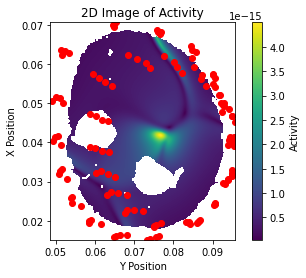

In [22]:
z = 7

# Plot the 2D image
plt.imshow(grid[:,:,z], extent=[y_min, y_max, x_min, x_max], origin='lower', cmap='viridis')
plt.colorbar(label='Activity')

plt.scatter(electrode_pos[:, 1], electrode_pos[:, 0], c='r', marker='o')
plt.xlabel('Y Position')
plt.ylabel('X Position')
plt.title('2D Image of Activity')
plt.show()

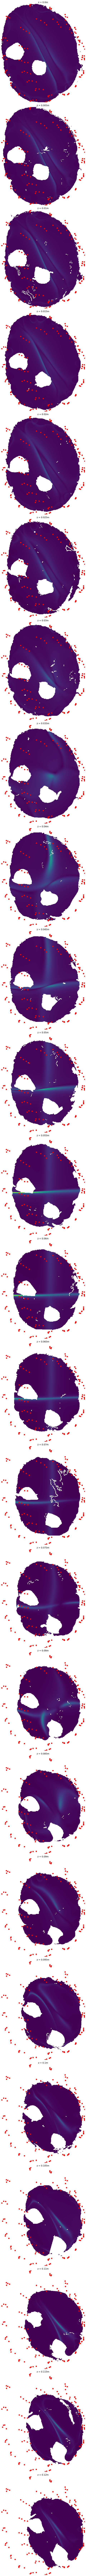

In [23]:
# Plot all the slices
num_slices = grid.shape[2]

# Create subplots
fig, axes = plt.subplots(num_slices, 1, figsize=(8, 200))

# Plot each slice
for z in range(num_slices):
    # Plot activity
    axes[z].imshow(grid[:,:,z], extent=[y_min, y_max, x_min, x_max], origin='lower', cmap='viridis', vmin=0, vmax=np.nanmax(grid) )
    # Plot electrode position
    axes[z].scatter(electrode_pos[:, 1], electrode_pos[:, 0], c='r', marker='o')
    axes[z].set_title(f'z = {z*zscaling}m')
    axes[z].axis('off')

# fig.colorbar(axes[0].imshow(labels[:, :, 0], cmap='viridis'), ax=axes, orientation='vertical')

# Display the plot
plt.tight_layout()
plt.show()

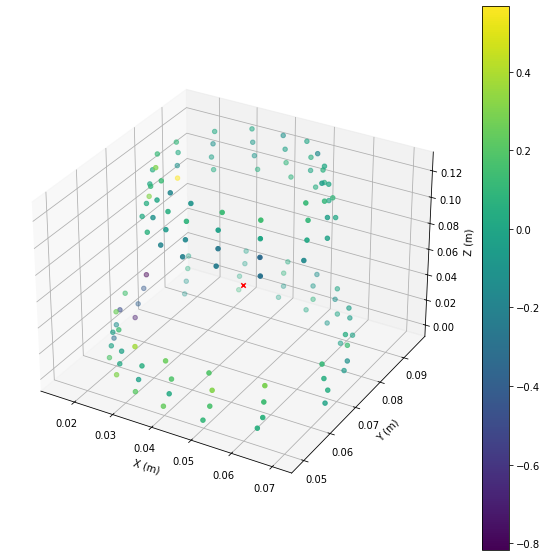

In [24]:
# Plot 3D image of electrode positions and select dipole positions

# Timepoint to plot
t = 20
# othergoods = np.where(save_arr[:,0,t] < 3)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the electrode positions
p = ax.scatter(electrode_pos[:, 0], electrode_pos[:, 1], electrode_pos[:, 2], c=muaps[:,t], marker='o', )

# Centroid
weighted_centroid = find_weighted_centroid(pos, source_activity, fixedorient=False)
ax.scatter(weighted_centroid[0], weighted_centroid[1], weighted_centroid[2], c='r', marker='x')
# Optimal Dipoles
# ax.scatter(optimal_dipoles[0][:,0], optimal_dipoles[0][:,1], optimal_dipoles[0][:,2],  c='r', marker='x', s=50) #s=np.linalg.norm(optimal_dipoles[1])*1e7
# Best Dipole
# ax.scatter(pos[best_index[t],0], pos[best_index[t],1], pos[best_index[t],2], c='r', marker='x', s=50, )
# Other goods
# ax.scatter(pos[othergoods,0], pos[othergoods,1], pos[othergoods,2], c='g', marker='v', s=5, alpha=0.1, ) 

fig.colorbar(p, ax=ax)

# Set labels
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')

plt.show()